In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import category_encoders as ce
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.base import clone

In [129]:
# HCP Dataset – starter pipeline (cleaning + feature engineering)
PATH = "HCP Dataset for Case Study.csv"   # adjust if needed

# ----------------------------
# 1) Load
# ----------------------------
df = pd.read_csv(PATH)


In [130]:
df.head()

,InsurerIdentifier,EpisodeIdentifier,DateOfBirth,Postcode,Sex,AdmissionDate,SeparationDate,HospitalType,ICU_Days,ICU_Hours,...,BundledCharges,HIH_Charges,SCN_Charges,CCU_Charges,SCN_Hours,CCU_Hours,SCN_Days,CCU_Days,QualifiedDaysNewborns,PalliativeCareDays
0,INS1,1624122,1012000,6280,1,1012023,2012023,2,0,0,...,316700,0,0,0,0,0,0,0,0,0
1,INS5,1624177,1011937,6233,2,1012023,6012023,2,0,0,...,696100,0,0,0,0,0,0,0,0,0
2,INS9,1624113,1011968,6225,2,1012023,9012023,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,,1624005,1011955,6281,1,1022023,1022023,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,,1625135,1011963,6230,1,1022023,1022023,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30615 entries, 0 to 30614
Columns: 162 entries, InsurerIdentifier to PalliativeCareDays
dtypes: int64(45), object(117)
memory usage: 37.8+ MB


In [132]:
df.dtypes

InsurerIdentifier        object
EpisodeIdentifier         int64
DateOfBirth               int64
Postcode                  int64
Sex                       int64
                          ...  
CCU_Hours                 int64
SCN_Days                  int64
CCU_Days                  int64
QualifiedDaysNewborns     int64
PalliativeCareDays        int64
Length: 162, dtype: object

## Convert columns to correct types

In [133]:
# ----------------------------
# Columns that should be OBJECT (categorical / identifiers / codes)
# ----------------------------

object_cols = [
    # Identifiers
    "InsurerIdentifier",
    "EpisodeIdentifier",
    "TransferInProviderNumber",
    "TransferOutProviderNumber",
    "Postcode",

    # Clinical & administrative codes
    "DRG",
    "DRG_Version",
    "PrincipalDiagnosis",

    # Demographics & episode attributes
    "Sex",
    "HospitalType",
    "UrgencyOfAdmission",
    "CareType",
    "SourceOfReferral",
    "DischargeIntention",
    "ModeOfSeparation",
    "SameDayStatus",
    "MentalHealthLegalStatus",
    "PalliativeCareStatus",
    "InterHospitalContracted",
    "Readmission28Days",
    "UnplannedTheatreVisit",

    # Time-of-day fields (parse later)
    "AdmissionTime",
    "SeparationTime",

    # MBS item numbers (codes, not numeric)
    "PrincipalMBS_ItemNumber"
]

# Add AdditionalDiagnosis1–49
object_cols += [f"AdditionalDiagnosis{i}" for i in range(1, 50)]

# Add Procedure1–50
object_cols += [f"Procedure{i}" for i in range(1, 51)]

# Add SecondaryMBS_ItemNumber1–9
object_cols += [f"SecondaryMBS_ItemNumber{i}" for i in range(1, 10)]

# ----------------------------
# Convert to object safely
# ----------------------------

for col in object_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)
#Sanity check
df[object_cols].dtypes.value_counts()

object    132
Name: count, dtype: int64

In [134]:
# ----------------------------
# Columns that should be NUMERIC
# ----------------------------

numeric_cols = [
    # Resource utilisation
    "ICU_Days",
    "ICU_Hours",
    "TotalPyschCareDays",
    "HoursMechVentilation",
    "TheatreMinutes",
    "TotalLeaveDays",
    "NonCertifiedDays",
    "HIH_Days",
    "SCN_Days",
    "CCU_Days",
    "SCN_Hours",
    "CCU_Hours",
    "QualifiedDaysNewborns",
    "PalliativeCareDays",
    "InfantWeight",

    # Charges
    "AccommodationCharge",
    "TheatreCharge",
    "LabourWardCharge",
    "ICU_Charge",
    "ProsthesisCharge",
    "PharmacyCharge",
    "OtherCharges",
    "BundledCharges",
    "HIH_Charges",
    "SCN_Charges",
    "CCU_Charges"
]

# ----------------------------
# Convert numeric columns safely
# ----------------------------

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df[numeric_cols].dtypes

ICU_Days                 int64
ICU_Hours                int64
TotalPyschCareDays       int64
HoursMechVentilation     int64
TheatreMinutes           int64
TotalLeaveDays           int64
NonCertifiedDays         int64
HIH_Days                 int64
SCN_Days                 int64
CCU_Days                 int64
SCN_Hours                int64
CCU_Hours                int64
QualifiedDaysNewborns    int64
PalliativeCareDays       int64
InfantWeight             int64
AccommodationCharge      int64
TheatreCharge            int64
LabourWardCharge         int64
ICU_Charge               int64
ProsthesisCharge         int64
PharmacyCharge           int64
OtherCharges             int64
BundledCharges           int64
HIH_Charges              int64
SCN_Charges              int64
CCU_Charges              int64
dtype: object

### Derive LOS variables

In [135]:
def parse_hcp_date(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    s = s.str.replace(r"\.0$", "", regex=True)
    s = s.str.zfill(8)  # DDMMYYYY
    return pd.to_datetime(s, format="%d%m%Y", errors="coerce")

def parse_hcp_time_to_hhmm(series: pd.Series) -> pd.Series:
    """
    Returns a 'HH:MM' string suitable for combining into datetime.
    """
    s = series.astype(str).str.strip()
    s = s.str.replace(r"\.0$", "", regex=True)
    s = s.str.zfill(4)  # HHMM
    # Validate HHMM ranges (optional but helpful)
    hh = pd.to_numeric(s.str[:2], errors="coerce")
    mm = pd.to_numeric(s.str[2:], errors="coerce")
    invalid = (hh > 23) | (mm > 59)
    s = s.mask(invalid, other=np.nan)
    return s.str[:2] + ":" + s.str[2:]

# --- 1) Parse date columns ---
for c in ["AdmissionDate", "SeparationDate", "DateOfBirth", "PrincipalMBS_ItemDate"]:
    if c in df.columns:
        df[c] = parse_hcp_date(df[c])

# --- 2) Parse time columns into HH:MM strings ---
for c in ["AdmissionTime", "SeparationTime"]:
    if c in df.columns:
        df[c] = parse_hcp_time_to_hhmm(df[c])

# --- 3) Combine into true datetimes (dtype: datetime64[ns]) ---
# If time is missing, default to 00:00 to avoid losing the row
df["AdmissionDateTime"] = pd.to_datetime(
    df["AdmissionDate"].dt.strftime("%Y-%m-%d") + " " + df["AdmissionTime"].fillna("00:00"),
    errors="coerce"
)

df["SeparationDateTime"] = pd.to_datetime(
    df["SeparationDate"].dt.strftime("%Y-%m-%d") + " " + df["SeparationTime"].fillna("00:00"),
    errors="coerce"
)

# Confirm dtype
print(df["AdmissionDateTime"].dtype, df["SeparationDateTime"].dtype)  # datetime64[ns]

# --- 4) Derive LOS ---
df["los_hours"] = (df["SeparationDateTime"] - df["AdmissionDateTime"]).dt.total_seconds() / 3600
df["los_days"]  = df["los_hours"] / 24

# Guardrails: negative LOS usually indicates data errors (or time parsing issues)
df.loc[df["los_hours"] < 0, ["los_hours", "los_days"]] = np.nan

# Optional: quick check
df[["AdmissionDateTime", "SeparationDateTime", "los_hours", "los_days"]].head(10)


datetime64[ns] datetime64[ns]


C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\3167115859.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["AdmissionDateTime"] = pd.to_datetime(
C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\3167115859.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["SeparationDateTime"] = pd.to_datetime(
C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\3167115859.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

,AdmissionDateTime,SeparationDateTime,los_hours,los_days
0,2023-01-01 08:50:00,2023-01-02 09:00:00,24.166667,1.006944
1,2023-01-01 13:30:00,2023-01-06 10:02:00,116.533333,4.855556
2,2023-01-01 11:55:00,2023-01-09 11:37:00,191.700000,7.987500
3,2023-02-01 10:37:00,2023-02-01 14:16:00,3.650000,0.152083
4,2023-02-01 13:07:00,2023-02-01 14:26:00,1.316667,0.054861
5,2023-02-01 08:51:00,2023-02-01 09:59:00,1.133333,0.047222
6,2023-02-01 15:33:00,2023-02-01 18:32:00,2.983333,0.124306
7,2023-02-01 07:00:00,2023-02-01 12:15:00,5.250000,0.218750
8,2023-02-01 07:00:00,2023-02-01 11:43:00,4.716667,0.196528
9,2023-02-01 07:00:00,2023-02-01 11:40:00,4.666667,0.194444


### Derive Age of admission

In [136]:
if {"DateOfBirth", "AdmissionDate"}.issubset(df.columns):
    df["age_at_admission"] = (df["AdmissionDate"] - df["DateOfBirth"]).dt.days / 365.25

df[["age_at_admission"]].head()

C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\4103739575.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["age_at_admission"] = (df["AdmissionDate"] - df["DateOfBirth"]).dt.days / 365.25


,age_at_admission
0,23.000684
1,85.998631
2,55.000684
3,68.084873
4,60.084873


### Diagnosis & Procedure burden

In [137]:
dx_cols = [c for c in df.columns if c.startswith("AdditionalDiagnosis")]
proc_cols = [c for c in df.columns if c.startswith("Procedure")]

def nonempty_count(row: pd.Series) -> int:
    # counts values that are not null/empty/"0"
    s = row.astype(str).str.strip()
    s = s.replace({"nan": "", "None": "", "0": ""})
    return (s != "").sum()

if dx_cols:
    df["num_additional_diagnoses"] = df[dx_cols].apply(nonempty_count, axis=1)

if proc_cols:
    df["num_procedures"] = df[proc_cols].apply(nonempty_count, axis=1)
    df["any_procedure_flag"] = df["num_procedures"] > 0

C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\594930829.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["num_additional_diagnoses"] = df[dx_cols].apply(nonempty_count, axis=1)
C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\594930829.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["num_procedures"] = df[proc_cols].apply(nonempty_count, axis=1)
C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\594930829.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

### Secondary MBS item count - for diagnostic only

In [138]:
sec_mbs_cols = [f"SecondaryMBS_ItemNumber{i}" for i in range(1, 10) if f"SecondaryMBS_ItemNumber{i}" in df.columns]

if sec_mbs_cols:
    df["num_secondary_mbs_items"] = (
        df[sec_mbs_cols]
        .astype(str)
        .replace({"nan": "", "None": ""})
        .ne("")
        .sum(axis=1)
    )

C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\2669290242.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["num_secondary_mbs_items"] = (


### CCU & SCN

In [139]:
# CCU exposure features
if "CCU_Days" in df.columns or "CCU_Hours" in df.columns:
    ccu_days = df["CCU_Days"].fillna(0) if "CCU_Days" in df.columns else 0
    ccu_hours = df["CCU_Hours"].fillna(0) if "CCU_Hours" in df.columns else 0

    df["ccu_flag"] = (ccu_days > 0) | (ccu_hours > 0)

C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\2394613598.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["ccu_flag"] = (ccu_days > 0) | (ccu_hours > 0)


In [140]:
# SCN exposure features
if "SCN_Days" in df.columns or "SCN_Hours" in df.columns:
    scn_days = df["SCN_Days"].fillna(0) if "SCN_Days" in df.columns else 0
    scn_hours = df["SCN_Hours"].fillna(0) if "SCN_Hours" in df.columns else 0

    df["scn_flag"] = (scn_days > 0) | (scn_hours > 0)

C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\1610982848.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["scn_flag"] = (scn_days > 0) | (scn_hours > 0)


In [141]:
# neonatal flag
for col in ["InfantWeight", "QualifiedDaysNewborns"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Neonatal flag
df["neonatal_flag"] = (
    (df["InfantWeight"].notna() & (df["InfantWeight"] > 0)) |
    (df["QualifiedDaysNewborns"].fillna(0) > 0)
)

C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\1069352586.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["neonatal_flag"] = (


In [142]:
# HIH
for col in ["HIH_Days", "HIH_Charges"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# HIH flag
df["hih_flag"] = (
    (df["HIH_Days"].fillna(0) > 0) |
    (df["HIH_Charges"].fillna(0) > 0)
)

C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\712039783.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["hih_flag"] = (


### Seasonality

In [143]:
# Seasonality features (Australia)
if "AdmissionDate" in df.columns:
    df["admission_month"] = df["AdmissionDate"].dt.month
    df["admission_quarter"] = df["AdmissionDate"].dt.quarter
    df["admission_year"] = df["AdmissionDate"].dt.year

    def season_au(m):
        if m in (12, 1, 2): return "Summer"
        if m in (3, 4, 5):  return "Autumn"
        if m in (6, 7, 8):  return "Winter"
        return "Spring"

    df["season_au"] = df["admission_month"].apply(lambda x: season_au(int(x)) if pd.notna(x) else np.nan)

    # Optional cyclical encoding (useful for linear models)
    df["month_sin"] = np.sin(2 * np.pi * df["admission_month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["admission_month"] / 12)

C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\1426013150.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["admission_month"] = df["AdmissionDate"].dt.month
C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\1426013150.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["admission_quarter"] = df["AdmissionDate"].dt.quarter
C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\1426013150.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

### Total cost column

In [144]:
# ----------------------------
# Total episode cost
# ----------------------------

charge_cols = [
    "AccommodationCharge",
    "TheatreCharge",
    "LabourWardCharge",
    "ICU_Charge",
    "ProsthesisCharge",
    "PharmacyCharge",
    "OtherCharges",
    "BundledCharges",
    "HIH_Charges",
    "SCN_Charges",
    "CCU_Charges"
]

# Keep only columns that exist
charge_cols = [c for c in charge_cols if c in df.columns]

# Ensure numeric (defensive)
for c in charge_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# Total cost (PRIMARY RESPONSE VARIABLE)
df["total_charges"] = df[charge_cols].sum(axis=1)


C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\2835312640.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["total_charges"] = df[charge_cols].sum(axis=1)


In [145]:
# Log-transform to handle heavy right skew
df["log_total_charges"] = np.log1p(df["total_charges"])

C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\1472366684.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["log_total_charges"] = np.log1p(df["total_charges"])


#### Cost mix proportions - only used for descriptions, not prediction

In [146]:
# ----------------------------
# Cost mix proportions
# ----------------------------

# Avoid divide-by-zero
df["has_cost"] = df["total_charges"] > 0

def share(col):
    return np.where(
        df["has_cost"],
        df[col] / df["total_charges"],
        np.nan
    )

if "TheatreCharge" in df.columns:
    df["pct_theatre"] = share("TheatreCharge")

if "ProsthesisCharge" in df.columns:
    df["pct_prosthesis"] = share("ProsthesisCharge")

if "ICU_Charge" in df.columns:
    df["pct_icu"] = share("ICU_Charge")

if "BundledCharges" in df.columns:
    df["pct_bundled"] = share("BundledCharges")

if "AccommodationCharge" in df.columns:
    df["pct_accommodation"] = share("AccommodationCharge")

df[
    ["pct_theatre","pct_prosthesis","pct_icu","pct_bundled","pct_accommodation"]
].describe()


C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\2729875961.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["has_cost"] = df["total_charges"] > 0
C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\2729875961.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["pct_theatre"] = share("TheatreCharge")
C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\2729875961.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

,pct_theatre,pct_prosthesis,pct_icu,pct_bundled,pct_accommodation
count,30185.000000,30185.000000,30185.0,30185.000000,30185.000000
mean,0.042798,0.040665,0.0,0.428710,0.486464
std,0.156279,0.111848,0.0,0.470112,0.480754
min,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.267951
75%,0.000000,0.000000,0.0,1.000000,1.000000
max,1.000000,1.000000,0.0,1.000000,1.000000


### Drop unneccsary columms

In [147]:
# ----------------------------
# Columns to DROP (non-relevant for episode-level analysis)
# ----------------------------

drop_cols = [

    # Raw diagnosis codes (kept only via aggregated counts)
    *[f"AdditionalDiagnosis{i}" for i in range(1, 50)],
    "PrincipalDiagnosis",

    # Raw procedure codes (kept only via aggregated counts)
    *[f"Procedure{i}" for i in range(1, 51)],

    # MBS item details (not needed for episode-level costing)
    "PrincipalMBS_ItemNumber",
    "PrincipalMBS_ItemDate",
    *[f"SecondaryMBS_ItemNumber{i}" for i in range(1, 10)],

    # Transfer & provider routing (not relevant for cost expectation)
    "TransferInProviderNumber",
    "TransferOutProviderNumber",

    # All ICU columns are 0 so just drop them
    "ICU_Days", "ICU_Hours",

    # DRG versioning (retain DRG only)
    "DRG_Version"
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns])


In [148]:
#DRG column is meaningful and should be converted to categorical
df["DRG"] = df["DRG"].astype("category")


In [149]:
# Export transformed dataset to CSV
output_path = "HCP_transformed_dataset.csv"

df.to_csv(output_path, index=False)

print(f"Saved to {output_path}")


Saved to HCP_transformed_dataset.csv


# Anomaly check

In [150]:
anomalies = {}

# Palliative
if "PalliativeCareDays" in df.columns:
    df["PalliativeCareDays"] = pd.to_numeric(df["PalliativeCareDays"], errors="coerce").fillna(0)

# Status ↔ days inconsistencies
if {"PalliativeCareStatus", "PalliativeCareDays"}.issubset(df.columns):
    # Days recorded but status not indicating palliative (you mentioned status=2 specifically)
    anomalies["pall_days_gt0_status_2"] = df[
        (df["PalliativeCareDays"] > 0) & (df["PalliativeCareStatus"].astype(str) == "2")
    ]

    # Status indicates palliative (you mentioned status=1) but zero days
    anomalies["pall_status_1_days_0"] = df[
        (df["PalliativeCareStatus"].astype(str) == "1") & (df["PalliativeCareDays"] == 0)
    ]


In [151]:
def unit_charge_flag_anomalies(df, unit_name, flag_col, charge_col):
    """
    Flags inconsistencies:
      - flag TRUE but charges = 0
      - charges > 0 but flag FALSE
    """
    out = {}

    if flag_col in df.columns and charge_col in df.columns:
        df[charge_col] = pd.to_numeric(df[charge_col], errors="coerce").fillna(0)

        out[f"{unit_name}_flag_true_charge_0"] = df[(df[flag_col] == True) & (df[charge_col] == 0)]
        out[f"{unit_name}_charge_gt0_flag_false"] = df[(df[charge_col] > 0) & (df[flag_col] == False)]

    return out

# CCU
anomalies.update(unit_charge_flag_anomalies(df, "ccu", "ccu_flag", "CCU_Charges"))

# SCN
anomalies.update(unit_charge_flag_anomalies(df, "scn", "scn_flag", "SCN_Charges"))

# HIH
anomalies.update(unit_charge_flag_anomalies(df, "hih", "hih_flag", "HIH_Charges"))


In [152]:
# Count anomalies by type
{k: v.shape[0] for k, v in anomalies.items()}


{'pall_days_gt0_status_2': 69,
 'pall_status_1_days_0': 24,
 'ccu_flag_true_charge_0': 703,
 'ccu_charge_gt0_flag_false': 0,
 'scn_flag_true_charge_0': 2,
 'scn_charge_gt0_flag_false': 0,
 'hih_flag_true_charge_0': 4,
 'hih_charge_gt0_flag_false': 0}

In [153]:
#Inspect a specific anomaly table
cols_show = [
    "EpisodeIdentifier", "DRG", "los_days",
    "PalliativeCareStatus", "PalliativeCareDays",
    "ccu_flag", "CCU_Charges",
    "scn_flag", "SCN_Charges",
    "hih_flag", "HIH_Charges",
    "total_charges"
]
cols_show = [c for c in cols_show if c in df.columns]

anomalies["ccu_flag_true_charge_0"][cols_show].head(20)


,EpisodeIdentifier,DRG,los_days,PalliativeCareStatus,PalliativeCareDays,ccu_flag,CCU_Charges,scn_flag,SCN_Charges,hih_flag,HIH_Charges,total_charges
61,1629401,F10B,2.152778,2,0,True,0,False,0,False,0,1068993
89,1629540,F42B,1.195833,2,0,True,0,False,0,False,0,405700
175,1634726,F10B,1.102778,2,0,True,0,False,0,False,0,1068993
180,1634743,F10B,2.728472,2,0,True,0,False,0,False,0,1068993
181,1634568,F10A,6.684028,2,0,True,0,False,0,False,0,1952780
381,1651628,F24B,0.387500,2,0,True,0,False,0,False,0,890341
508,1594201,F61B,3.660417,2,0,True,0,False,0,False,0,1310041
509,1594216,F62B,4.277778,2,0,True,0,False,0,False,0,523840
604,1599230,F10B,1.825000,2,0,True,0,False,0,False,0,1068993
606,1599232,F76A,8.800694,2,0,True,0,False,0,False,0,630844


In [154]:
# Theatre minutes ↔ theatre charges
if {"TheatreMinutes", "TheatreCharge"}.issubset(df.columns):
    df["TheatreMinutes"] = pd.to_numeric(df["TheatreMinutes"], errors="coerce").fillna(0)
    df["TheatreCharge"]  = pd.to_numeric(df["TheatreCharge"], errors="coerce").fillna(0)

    anomalies["theatre_charge_gt0_minutes_0"] = df[(df["TheatreCharge"] > 0) & (df["TheatreMinutes"] == 0)]
    anomalies["theatre_minutes_gt0_charge_0"] = df[(df["TheatreMinutes"] > 0) & (df["TheatreCharge"] == 0)]


In [155]:
# Neonatal flag ↔ newborn days
if "QualifiedDaysNewborns" in df.columns:
    df["QualifiedDaysNewborns"] = pd.to_numeric(df["QualifiedDaysNewborns"], errors="coerce").fillna(0)

if {"neonatal_flag", "QualifiedDaysNewborns"}.issubset(df.columns):
    anomalies["neonatal_flag_true_newborn_days_0"] = df[(df["neonatal_flag"] == True) & (df["QualifiedDaysNewborns"] == 0)]
    anomalies["newborn_days_gt0_neonatal_flag_false"] = df[(df["QualifiedDaysNewborns"] > 0) & (df["neonatal_flag"] == False)]


In [156]:
# Zero cost but LOS > 0
if {"total_charges", "los_days"}.issubset(df.columns):
    anomalies["los_gt0_total_charges_0"] = df[(df["los_days"] > 0) & (df["total_charges"] == 0)]


In [157]:
# Same-day status inconsistent with LOS
if {"SameDayStatus", "los_days"}.issubset(df.columns):
    anomalies["same_day_but_los_gt1"] = df[df["SameDayStatus"].notna() & (df["los_days"] > 1)]


### Anomaly summary

In [158]:
anomaly_counts = (
    pd.Series({k: v.shape[0] for k, v in anomalies.items()})
      .sort_values(ascending=False)
)
anomaly_counts


theatre_minutes_gt0_charge_0            9510
same_day_but_los_gt1                    5536
ccu_flag_true_charge_0                   703
los_gt0_total_charges_0                  430
neonatal_flag_true_newborn_days_0        314
pall_days_gt0_status_2                    69
theatre_charge_gt0_minutes_0              43
pall_status_1_days_0                      24
hih_flag_true_charge_0                     4
scn_flag_true_charge_0                     2
scn_charge_gt0_flag_false                  0
ccu_charge_gt0_flag_false                  0
hih_charge_gt0_flag_false                  0
newborn_days_gt0_neonatal_flag_false       0
dtype: int64

### Cost mix proportion structural analysis

In [159]:
cost_mix_cols = [
    "pct_theatre",
    "pct_prosthesis",
    "pct_icu",
    "pct_bundled",
    "pct_accommodation"
]

cost_mix_cols = [c for c in cost_mix_cols if c in df.columns]

outliers = {}

for col in cost_mix_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers[col] = df[
        (df[col] < lower_bound) | (df[col] > upper_bound)
    ]

# Summary counts
{col: outliers[col].shape[0] for col in outliers}


{'pct_theatre': 2403,
 'pct_prosthesis': 5494,
 'pct_icu': 0,
 'pct_bundled': 0,
 'pct_accommodation': 0}

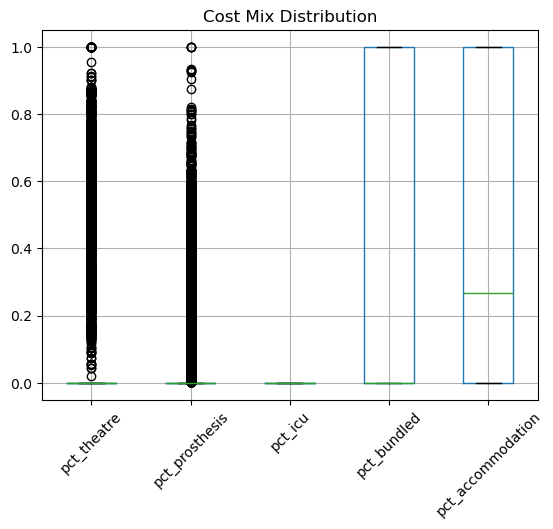

In [160]:
# quick visual check
df[cost_mix_cols].boxplot(rot=45)
plt.title("Cost Mix Distribution")
plt.show()


Cost mix distributions are highly concentrated at zero for theatre and prosthesis components, reflecting distinct clinical pathways (surgical vs non-surgical episodes). Traditional IQR-based outlier detection therefore flags structural variation rather than billing anomalies.

### Extreme Cost Concentration Analysis

In [161]:
# ==============================
# Extreme Cost Concentration Analysis
# ==============================

threshold = 0.8

# Ensure proportions are numeric
for col in ["pct_prosthesis", "pct_theatre"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# 1️⃣ Create dominance flags
df["prosthesis_dominant_flag"] = df.get("pct_prosthesis", 0) > threshold
df["theatre_dominant_flag"] = df.get("pct_theatre", 0) > threshold

# 2️⃣ Combined concentration flag
df["extreme_cost_concentration_flag"] = (
    df["prosthesis_dominant_flag"] |
    df["theatre_dominant_flag"]
)

# 3️⃣ Summary counts
summary_counts = df[
    ["prosthesis_dominant_flag", "theatre_dominant_flag", "extreme_cost_concentration_flag"]
].sum()

print("=== Dominance Counts ===")
print(summary_counts)

# 4️⃣ Financial exposure
if "total_charges" in df.columns:
    total_exposure = df.loc[
        df["extreme_cost_concentration_flag"], 
        "total_charges"
    ].sum()

    pct_revenue = total_exposure / df["total_charges"].sum()

    print("\n=== Financial Exposure ===")
    print(f"Total concentration revenue: ${total_exposure:,.0f}")
    print(f"Percentage of total revenue: {pct_revenue:.2%}")

# 5️⃣ Top flagged cases
cols_to_view = [
    "EpisodeIdentifier",
    "DRG",
    "total_charges",
    "pct_prosthesis",
    "pct_theatre",
    "ProsthesisCharge",
    "TheatreCharge"
]

cols_to_view = [c for c in cols_to_view if c in df.columns]

print("\n=== Sample Flagged Cases ===")
display(df.loc[df["extreme_cost_concentration_flag"], cols_to_view].head(20))

# 6️⃣ DRG distribution of flagged cases
if "DRG" in df.columns:
    print("\n=== DRG Distribution (Top 10) ===")
    display(
        df.loc[df["extreme_cost_concentration_flag"], "DRG"]
        .value_counts()
        .head(10)
    )


=== Dominance Counts ===
prosthesis_dominant_flag            17
theatre_dominant_flag              180
extreme_cost_concentration_flag    197
dtype: int64

=== Financial Exposure ===
Total concentration revenue: $88,521,275
Percentage of total revenue: 1.08%

=== Sample Flagged Cases ===


,EpisodeIdentifier,DRG,total_charges,pct_prosthesis,pct_theatre,ProsthesisCharge,TheatreCharge
99,1624701,N07B,182800,0.000000,0.805799,0,147300
675,1599888,J10Z,363050,0.000000,0.816554,0,296450
1064,1624717,I68C,776965,0.000000,0.914282,0,710365
1282,1629894,I68C,497530,0.000000,0.861315,0,428530
1518,1594354,I13B,182800,0.000000,0.805799,0,147300
1558,1599559,O01B,231500,0.000000,1.000000,0,231500
1596,1594671,N07A,282900,0.000000,0.874514,0,247400
1601,1598195,F42C,508600,0.060362,0.819898,30700,417000
1704,1600276,I23A,182800,0.000000,0.805799,0,147300
1711,1601884,R04B,352400,0.011635,0.822645,4100,289900



=== DRG Distribution (Top 10) ===


DRG
I68C    27
F42C    27
N07Z     8
F15B     7
T64C     6
F69B     6
J06A     5
N07A     5
N07B     4
F76B     3
Name: count, dtype: int64

Extreme cost concentration is limited to a small subset of surgical pathways and represents just over 1% of revenue. Patterns are largely DRG-specific and structurally consistent, indicating no systemic billing distortion. However, prosthesis-dominant cases warrant targeted contract compliance review.

# Data exploratory analysis

In [162]:
#total charge segmentation
# Ensure numeric
df["total_charges"] = pd.to_numeric(df["total_charges"], errors="coerce")

# Remove zero or negative if needed (optional)
df_nonzero = df[df["total_charges"] > 0].copy()

# Calculate percentiles
p50 = df_nonzero["total_charges"].quantile(0.50)
p75 = df_nonzero["total_charges"].quantile(0.75)
p95 = df_nonzero["total_charges"].quantile(0.95)

print("Percentile thresholds:")
print(f"50th percentile: ${p50:,.0f}")
print(f"75th percentile: ${p75:,.0f}")
print(f"95th percentile: ${p95:,.0f}")

# Create segmentation
def cost_segment(x):
    if x <= p50:
        return "Low"
    elif x <= p75:
        return "Medium"
    elif x <= p95:
        return "High"
    else:
        return "Very High"

df["cost_segment"] = df["total_charges"].apply(cost_segment)

# Quick summary
segment_summary = df.groupby("cost_segment").agg(
    episodes=("EpisodeIdentifier", "count"),
    median_cost=("total_charges", "median"),
    total_revenue=("total_charges", "sum")
).sort_values("median_cost")

print("\n=== Cost Segment Summary ===")
display(segment_summary)


Percentile thresholds:
50th percentile: $65,000
75th percentile: $300,415
95th percentile: $1,262,427

=== Cost Segment Summary ===


,episodes,median_cost,total_revenue
cost_segment,,,
Low,16207,35710.0,671033381
Medium,7022,165200.0,1220592255
High,5876,548000.0,3639544536
Very High,1510,1723100.0,2690363838


Hospital episode costs exhibit clear Pareto behaviour — a small proportion of cases generate a disproportionately large share of total revenue.

In this dataset:

The High and Very High segments (~25% of episodes)

Account for the majority of total revenue (~75–80%)

With the top 5% alone contributing several billion dollars

This reflects the well-known 80/20 principle:

A minority of high-acuity, resource-intensive cases drive most financial performance.

Why This Matters for Stakeholders

1️ - Financial Risk & Revenue Integrity

The High and Very High segments:

Represent the greatest revenue exposure

Carry the highest insurer dispute risk

Require the strongest documentation and coding accuracy

Errors in this segment have a disproportionate financial impact.

2️ - Operational Resource Allocation

These cases:

Drive ICU/CCU utilisation

Consume the majority of theatre time

Require more specialised staffing

Operational planning should prioritise these high-value pathways.

3️ - Strategic Focus

Rather than auditing every case equally, governance and analytics should:

Prioritise the top 25% revenue-driving cases

Monitor cost concentration and variance

Protect margins in high-acuity DRGs

### Length of stay by cost segment

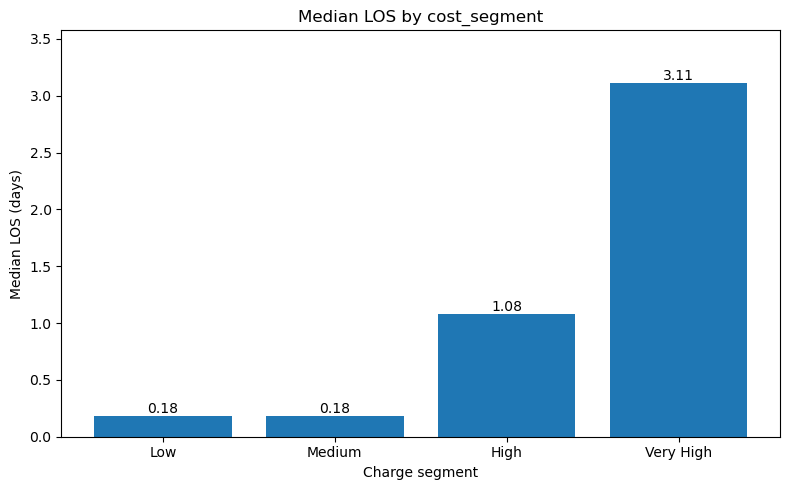

In [163]:
# Ensure LOS is numeric
df["los_days"] = pd.to_numeric(df["los_days"], errors="coerce")

# Calculate median LOS by cost_segment
los_summary = (
    df.groupby("cost_segment")["los_days"]
      .median()
      .reindex(["Low", "Medium", "High", "Very High"])  # enforce logical order
)

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(los_summary.index, los_summary.values)

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height,
             f"{height:.2f}",
             ha='center',
             va='bottom')

plt.title("Median LOS by cost_segment")
plt.xlabel("Charge segment")
plt.ylabel("Median LOS (days)")
plt.ylim(0, max(los_summary.values) * 1.15)

plt.tight_layout()
plt.show()


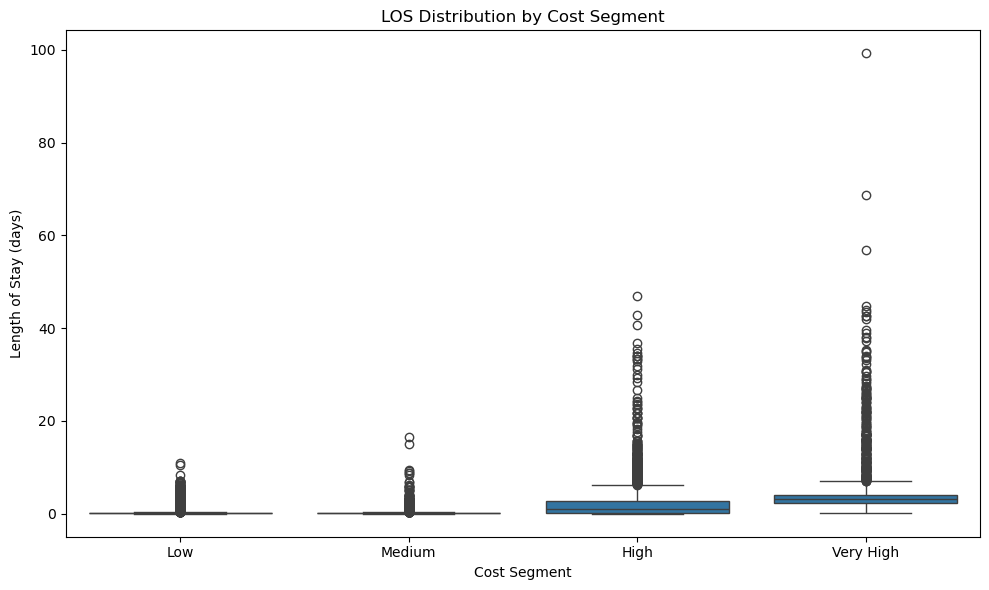

In [164]:
#LOS distribution
df["los_days"] = pd.to_numeric(df["los_days"], errors="coerce")

# Keep only valid LOS
df_plot = df[df["los_days"].notna()].copy()

# Enforce logical ordering
order = ["Low", "Medium", "High", "Very High"]

plt.figure(figsize=(10,6))

sns.boxplot(
    data=df_plot,
    x="cost_segment",
    y="los_days",
    order=order,
    showfliers=True
)

plt.title("LOS Distribution by Cost Segment")
plt.xlabel("Cost Segment")
plt.ylabel("Length of Stay (days)")

plt.tight_layout()
plt.show()

1- Median LOS by Cost Segment
Median LOS increases sharply across segments:
Low: 0.18 days
Medium: 0.18 days
High: 1.08 days
Very High: 3.11 days
What this means:
Low and Medium cases are overwhelmingly same-day or short-stay episodes.
High cases cross into multi-day inpatient territory.
Very High cases are clearly prolonged admissions.
There is a strong monotonic relationship:
As cost segment increases, median length of stay increases.
This suggests LOS is a key structural driver of cost.

2- LOS Distribution (Boxplot)
The boxplot adds depth:
A. Spread increases with cost
Low/Medium → tightly compressed around zero
High → wider distribution
Very High → significantly wider spread
This means:
Cost is not just higher — it is more variable.
Very High cases are operationally less predictable.

B. Heavy Right Tail in Very High
Very High shows:
Many long-stay outliers (20–40+ days)
Extreme cases approaching ~100 days
This indicates:
Complex inpatient pathways
Possibly delayed discharge
Complications
Rehabilitation or step-down waiting
High-acuity cases
This tail is important.
Because:
Extreme LOS cases likely drive disproportionate marginal cost.

3- Low & Medium Segments
They are:
Short stay
Operationally predictable
Likely procedural / day surgery driven
These are not your operational risk zones.

Operational Interpretation
Very High segment likely:
Drives bed occupancy pressure
Requires higher nursing intensity
Involves ICU / CCU exposure
Has higher discharge planning complexity
If hospital capacity is strained, this segment is where bottlenecks occur.

 Financial Interpretation
LOS directly increases:
Accommodation charges
Nursing labour
Overheads
Resource consumption
But the tail suggests:
A small number of extreme LOS cases could distort margins
These may require targeted clinical review

Strategic Insight
Cost escalation is strongly associated with prolonged hospital stay.
Narrative A — Operational Efficiency
If LOS is reducible:
Improve discharge planning
Early rehab referral
Bed management optimisation
Narrative B — Case Complexity
If LOS reflects unavoidable clinical complexity:
Focus on reimbursement alignment
DRG review

### Theatre usage by cost segment

% of High/Very High episodes with theatre use: 81.63%

Median Theatre Minutes by Segment:
cost_segment
Low            0.0
Medium        23.0
High          44.0
Very High    108.0
Name: TheatreMinutes, dtype: float64


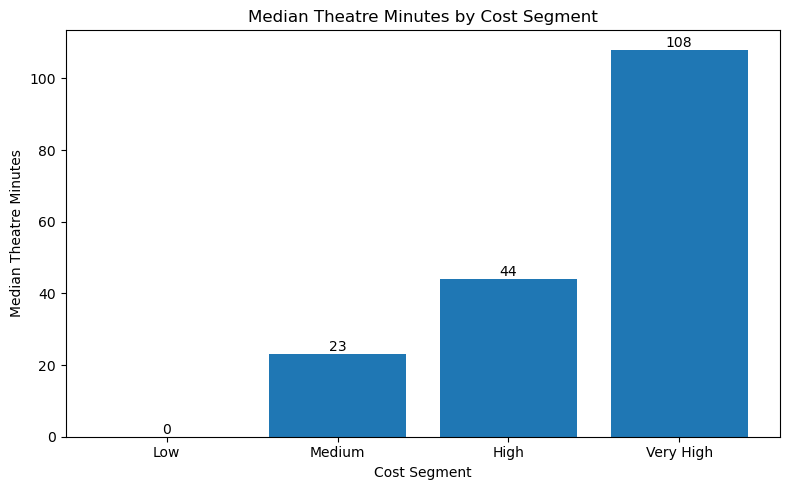

In [165]:
df["TheatreMinutes"] = pd.to_numeric(df["TheatreMinutes"], errors="coerce").fillna(0)

# Create theatre_flag if not already created
df["theatre_flag"] = df["TheatreMinutes"] > 0

# -----------------------------
# 1️ % of High / Very High with theatre use
# -----------------------------

high_segments = ["High", "Very High"]

high_df = df[df["cost_segment"].isin(high_segments)]

pct_theatre_high = (
    high_df["theatre_flag"].mean() * 100
)

print(f"% of High/Very High episodes with theatre use: {pct_theatre_high:.2f}%")

# -----------------------------
# 2️ Median theatre minutes by segment
# -----------------------------

median_theatre = (
    df.groupby("cost_segment")["TheatreMinutes"]
      .median()
      .reindex(["Low", "Medium", "High", "Very High"])
)

print("\nMedian Theatre Minutes by Segment:")
print(median_theatre)

# -----------------------------
# 3️ : Visual
# -----------------------------

plt.figure(figsize=(8,5))
bars = plt.bar(median_theatre.index, median_theatre.values)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height,
             f"{height:.0f}",
             ha='center',
             va='bottom')

plt.title("Median Theatre Minutes by Cost Segment")
plt.xlabel("Cost Segment")
plt.ylabel("Median Theatre Minutes")

plt.tight_layout()
plt.show()

1- 81.63% of High / Very High episodes involve theatre use
This is critical.
It tells us:
The majority of high-cost cases are procedure-driven.
High expenditure is not random.It is largely associated with surgical intervention.

2 Median Theatre Minutes Increase Systematically
Median theatre minutes by segment:
Low: 0 minutes
Medium: 23 minutes
High: 44 minutes
Very High: 108 minutes
This shows a clear monotonic relationship:
As cost segment increases, procedural intensity increases.
Very High cases involve:
~2.5x theatre time compared to High
~5x theatre time compared to Medium
No theatre involvement in Low
That’s a powerful structural insight.

 What This Means Operationally
Theatre utilisation is a major driver of cost concentration.
Specifically:
Low/Medium = mostly non-procedural or minor interventions
High = moderate procedures
Very High = long and complex procedures
Very High cases likely include:
Major orthopaedics
Complex cardiac surgery
Multi-hour procedures
Prosthesis-heavy interventions
This aligns with the Pareto pattern you showed earlier.

 Operational Implications
Theatre capacity becomes a key performance lever.
If 25% of episodes drive most revenue AND 82% of them require theatre:
Theatre scheduling efficiency matters
Turnover time matters
Utilisation optimisation matters
Staffing mix matters
Revenue protection is tightly linked to theatre operations.

 Financial Implications
Longer theatre time generally means:
Higher staffing cost
Higher consumable use
Higher prosthesis probability
Greater insurer scrutiny
Very High cases represent:
Higher margin volatility
Greater billing sensitivity
Greater contract dependency

 Linking LOS + Theatre Together
previously showed:
Very High median LOS = 3.11 days
High median LOS = 1.08 days
Now show:
Very High median theatre = 108 mins
High median theatre = 44 mins
This suggests:
Cost escalation is driven by both procedural intensity AND longer inpatient stay.
This is a dual driver model:
Procedural intensity
Post-operative resource utilisation

### CCU / SCN / HIH Usage by cost segment

=== Critical Care & HIH Exposure by Cost Segment ===


,% CCU Exposure,% SCN Exposure,% HIH Exposure
cost_segment,,,
Low,0.06,0.01,0.00
Medium,1.41,0.04,0.01
High,8.20,0.00,0.09
Very High,8.68,0.00,0.07


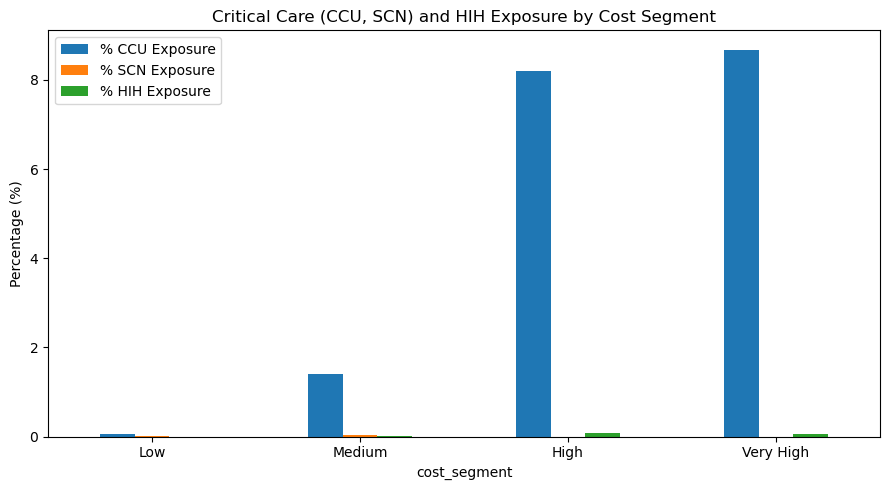

In [166]:
# -----------------------------
# % Exposure by Cost Segment
# -----------------------------

segment_order = ["Low", "Medium", "High", "Very High"]

exposure_summary = pd.DataFrame({
    "% CCU Exposure": (
        df.groupby("cost_segment")["ccu_flag"]
          .mean()
          .reindex(segment_order) * 100
    ),
    "% SCN Exposure": (
        df.groupby("cost_segment")["scn_flag"]
          .mean()
          .reindex(segment_order) * 100
    ),
    "% HIH Exposure": (
        df.groupby("cost_segment")["hih_flag"]
          .mean()
          .reindex(segment_order) * 100
    )
})

print("=== Critical Care & HIH Exposure by Cost Segment ===")
display(exposure_summary.round(2))

# -----------------------------
# Visual
# -----------------------------

exposure_summary.plot(kind="bar", figsize=(9,5))
plt.title("Critical Care (CCU, SCN) and HIH Exposure by Cost Segment")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


High-cost episodes are associated with greater critical care exposure compared to lower-cost cases; however, the marginal increase between High and Very High segments is modest. This indicates that while acuity contributes to cost concentration, procedural intensity and length of stay appear to be stronger structural drivers of financial concentration.

### DRG distribution

In [167]:
# Focus only on High and Very High
segments_of_interest = ["High", "Very High"]
df_hv = df[df["cost_segment"].isin(segments_of_interest)].copy()

# -----------------------------
# 1️⃣ DRG counts by segment
# -----------------------------

drg_counts = (
    df_hv.groupby(["cost_segment", "DRG"])
         .size()
         .reset_index(name="episode_count")
)

# Top 10 DRGs by episode count per segment
top_drg_counts = (
    drg_counts.sort_values(["cost_segment", "episode_count"], ascending=[True, False])
              .groupby("cost_segment")
              .head(10)
)

print("=== Top 10 DRGs by Episode Count ===")
display(top_drg_counts)

# -----------------------------
# 2️⃣ Revenue by DRG within segment
# -----------------------------

drg_revenue = (
    df_hv.groupby(["cost_segment", "DRG"])["total_charges"]
         .sum()
         .reset_index()
)

# Calculate revenue share within each segment
drg_revenue["segment_total"] = drg_revenue.groupby("cost_segment")["total_charges"].transform("sum")
drg_revenue["revenue_share_%"] = (
    drg_revenue["total_charges"] / drg_revenue["segment_total"] * 100
)

# Top 10 DRGs by revenue share
top_drg_revenue = (
    drg_revenue.sort_values(["cost_segment", "revenue_share_%"], ascending=[True, False])
               .groupby("cost_segment")
               .head(10)
)

print("\n=== Top 10 DRGs by Revenue Share (%) ===")
display(top_drg_revenue)

# -----------------------------
# 3️⃣ Concentration analysis
# -----------------------------

def concentration_summary(segment_name):
    temp = drg_revenue[drg_revenue["cost_segment"] == segment_name] \
            .sort_values("revenue_share_%", ascending=False)

    top5_share = temp.head(5)["revenue_share_%"].sum()
    top10_share = temp.head(10)["revenue_share_%"].sum()

    return pd.Series({
        "Top 5 DRGs Revenue Share (%)": top5_share,
        "Top 10 DRGs Revenue Share (%)": top10_share,
        "Total DRGs in Segment": temp.shape[0]
    })

concentration_table = pd.DataFrame({
    seg: concentration_summary(seg) for seg in segments_of_interest
}).T

print("\n=== DRG Concentration Summary ===")
display(concentration_table.round(2))

=== Top 10 DRGs by Episode Count ===


C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\3253554272.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_hv.groupby(["cost_segment", "DRG"])


,cost_segment,DRG,episode_count
264,High,I16Z,332
148,High,F42B,273
53,High,C16Z,247
199,High,G10B,177
235,High,H08B,118
211,High,G48A,115
144,High,F24B,105
129,High,F10B,99
467,High,O60B,95
436,High,N04B,91



=== Top 10 DRGs by Revenue Share (%) ===


C:\Users\60204567\AppData\Local\Temp\ipykernel_25448\3253554272.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_hv.groupby(["cost_segment", "DRG"])["total_charges"]


,cost_segment,DRG,total_charges,segment_total,revenue_share_%
264,High,I16Z,220548475,3639544536,6.059782
148,High,F42B,127035836,3639544536,3.490432
129,High,F10B,105343770,3639544536,2.894422
144,High,F24B,97692319,3639544536,2.684191
53,High,C16Z,85607435,3639544536,2.352147
372,High,K11Z,77790400,3639544536,2.137366
199,High,G10B,77004460,3639544536,2.115772
436,High,N04B,71010555,3639544536,1.951084
460,High,O01C,69411290,3639544536,1.907142
467,High,O60B,69320700,3639544536,1.904653



=== DRG Concentration Summary ===


,Top 5 DRGs Revenue Share (%),Top 10 DRGs Revenue Share (%),Total DRGs in Segment
High,17.48,27.5,555.0
Very High,55.99,65.3,555.0


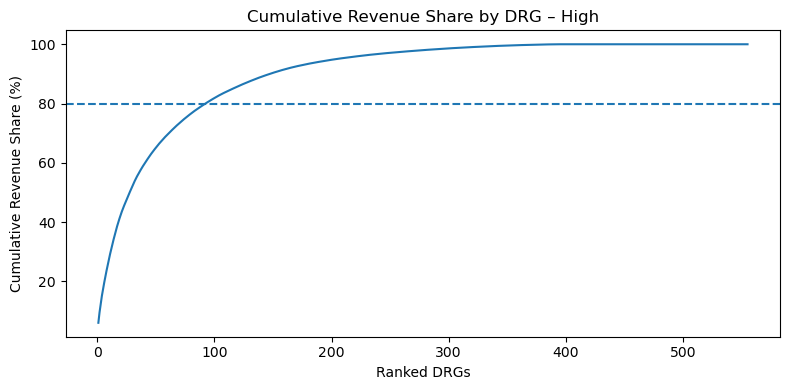

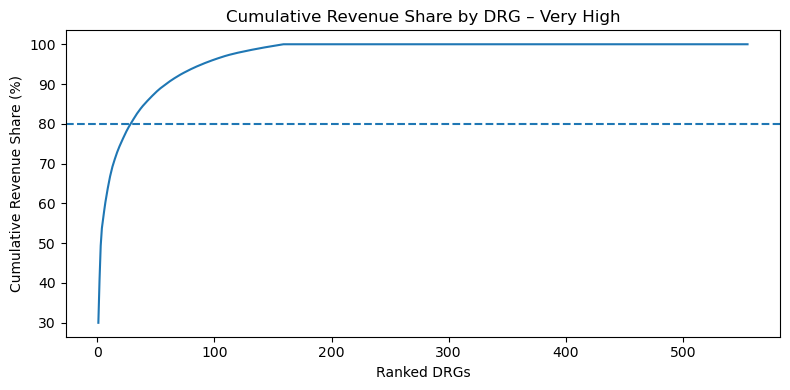

In [168]:
# -----------------------------
#  Visual – Revenue Concentration
# -----------------------------

for seg in segments_of_interest:
    temp = drg_revenue[drg_revenue["cost_segment"] == seg] \
            .sort_values("revenue_share_%", ascending=False)

    temp["cumulative_%"] = temp["revenue_share_%"].cumsum()

    plt.figure(figsize=(8,4))
    plt.plot(range(1, len(temp)+1), temp["cumulative_%"])
    plt.axhline(80, linestyle="--")
    plt.title(f"Cumulative Revenue Share by DRG – {seg}")
    plt.xlabel("Ranked DRGs")
    plt.ylabel("Cumulative Revenue Share (%)")
    plt.tight_layout()
    plt.show()

Very High episodes are financially concentrated in a small number of DRGs. The top 3 DRGs contribute ~50% of Very High revenue, indicating structural dependency on specific complex clinical pathways.
In contrast, High episodes are broadly distributed across many DRGs, reflecting a diversified surgical portfolio.
This suggests that financial risk, contract exposure, and operational pressure are disproportionately concentrated within a small set of high-complexity DRGs.
Focused governance, contract management, and operational optimisation in these pathways will deliver the greatest financial impact and risk protection.

### Urgency and care type analysis 

Top raw values: UrgencyOfAdmission
2    28312
3     1218
1     1085
Name: count, dtype: int64
Top cleaned codes: Urgency_code
2    28312
3     1218
1     1085
Name: count, dtype: Int64


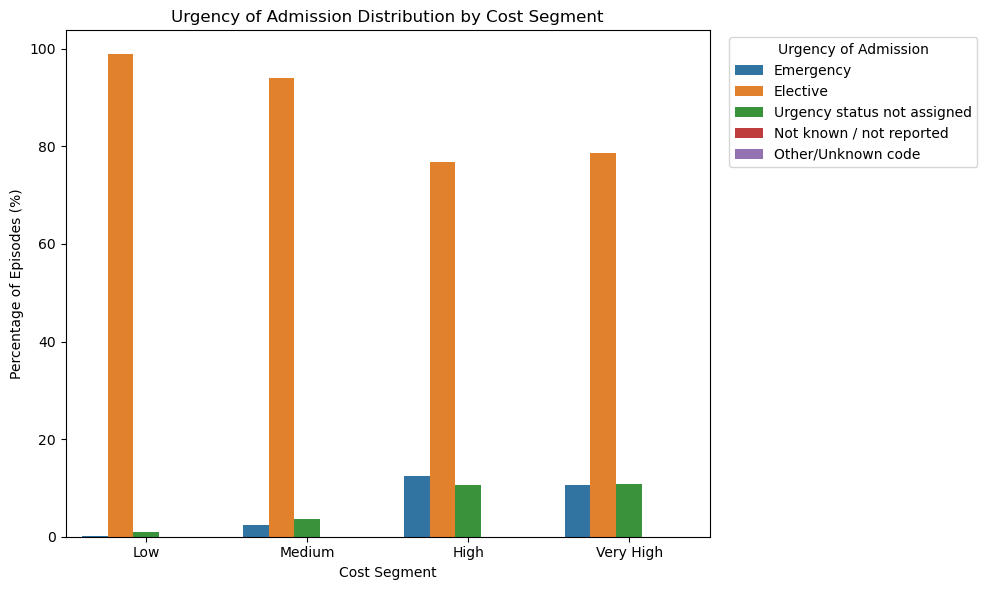

,cost_segment,urgency_label,episodes,segment_total,percentage
4,Low,Emergency,26,16207,0.16
3,Low,Elective,16016,16207,98.82
5,Low,Urgency status not assigned,165,16207,1.02
7,Medium,Emergency,164,7022,2.34
6,Medium,Elective,6598,7022,93.96
8,Medium,Urgency status not assigned,260,7022,3.70
1,High,Emergency,735,5876,12.51
0,High,Elective,4512,5876,76.79
2,High,Urgency status not assigned,629,5876,10.70
10,Very High,Emergency,160,1510,10.60


In [169]:
# 1) Clean UrgencyOfAdmission into a numeric code
urg_code = pd.to_numeric(df["UrgencyOfAdmission"], errors="coerce")

# If values are floats like 1.0, 2.0 etc, convert to nullable integer
df["Urgency_code"] = urg_code.round().astype("Int64")  # keeps <NA>

# 2) Map codes to labels
urgency_map = {
    1: "Emergency",
    2: "Elective",
    3: "Urgency status not assigned",
    9: "Not known / not reported"
}

df["urgency_label"] = df["Urgency_code"].map(urgency_map).fillna("Other/Unknown code")

# (Quick sanity check)
print("Top raw values:", df["UrgencyOfAdmission"].value_counts(dropna=False).head(10))
print("Top cleaned codes:", df["Urgency_code"].value_counts(dropna=False).head(10))

# 3) Build % distribution within each cost_segment
urgency_dist = (
    df.groupby(["cost_segment", "urgency_label"])
      .size()
      .reset_index(name="episodes")
)

urgency_dist["segment_total"] = urgency_dist.groupby("cost_segment")["episodes"].transform("sum")
urgency_dist["percentage"] = (urgency_dist["episodes"] / urgency_dist["segment_total"] * 100).round(2)

# 4) Plot (stacked 100% style using barplot per category)
segment_order = ["Low", "Medium", "High", "Very High"]
urgency_order = ["Emergency", "Elective", "Urgency status not assigned", "Not known / not reported", "Other/Unknown code"]

urgency_dist["cost_segment"] = pd.Categorical(urgency_dist["cost_segment"], categories=segment_order, ordered=True)
urgency_dist["urgency_label"] = pd.Categorical(urgency_dist["urgency_label"], categories=urgency_order, ordered=True)
urgency_dist = urgency_dist.sort_values(["cost_segment", "urgency_label"])

plt.figure(figsize=(10,6))
sns.barplot(
    data=urgency_dist,
    x="cost_segment",
    y="percentage",
    hue="urgency_label",
    order=segment_order
)
plt.title("Urgency of Admission Distribution by Cost Segment")
plt.xlabel("Cost Segment")
plt.ylabel("Percentage of Episodes (%)")
plt.legend(title="Urgency of Admission", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

urgency_dist


High and Very High cost episodes are predominantly elective rather than emergency-driven.This indicates that revenue concentration is driven by scheduled major procedures rather than acute complexity. As a result, theatre capacity, specialist workforce, prosthesis management, and contract optimisation represent key strategic levers for financial performance.

Emergency proportion increases sharply from:0.16% → 12.5%
So complexity does rise with cost —but the majority of revenue still comes from elective pathways.

#### Care type distribution

Top CareType codes:
CareType_code
1    29956
7      337
3      316
6        6
Name: count, dtype: Int64


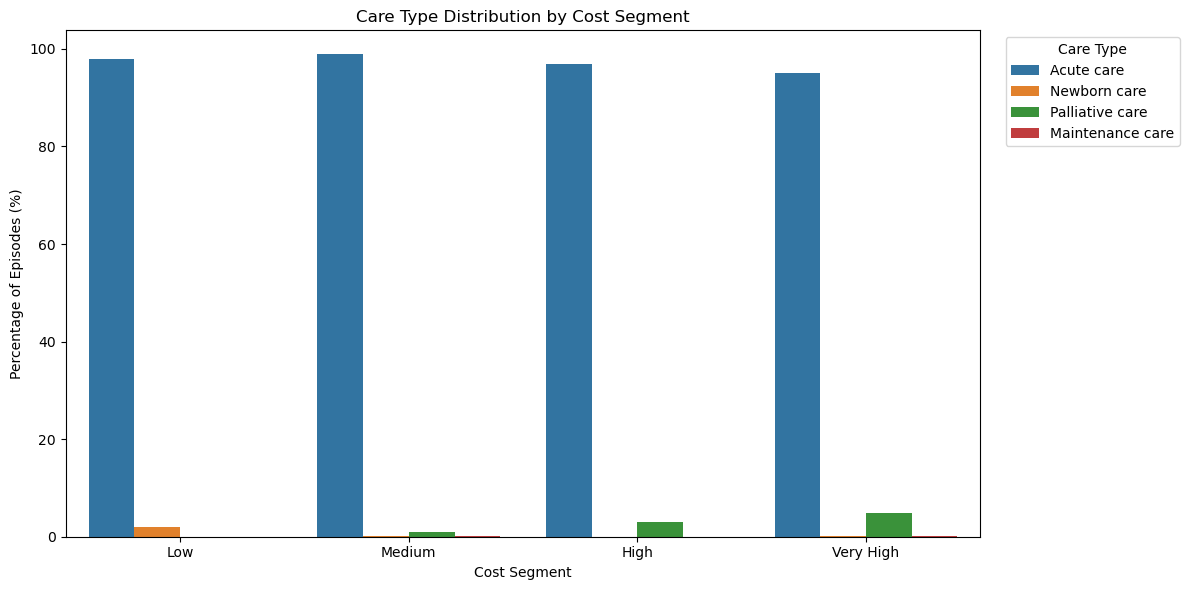

,cost_segment,caretype_label,episodes,segment_total,percentage
4,Low,Acute care,15879,16207,97.98
5,Low,Newborn care,326,16207,2.01
6,Low,Palliative care,2,16207,0.01
7,Medium,Acute care,6942,7022,98.86
10,Medium,Palliative care,68,7022,0.97
9,Medium,Newborn care,8,7022,0.11
8,Medium,Maintenance care,4,7022,0.06
0,High,Acute care,5700,5876,97.00
3,High,Palliative care,173,5876,2.94
2,High,Newborn care,2,5876,0.03


In [170]:
# 1️⃣ Clean CareType to numeric
care_code = pd.to_numeric(df["CareType"], errors="coerce")
df["CareType_code"] = care_code.round().astype("Int64")

# 2️⃣ Mapping dictionary
caretype_map = {
    1: "Acute care",
    2: "Rehabilitation care",
    3: "Palliative care",
    4: "Geriatric evaluation & management",
    5: "Psychogeriatric care",
    6: "Maintenance care",
    7: "Newborn care",
    11: "Mental health care",
    88: "Other admitted patient care",
    9: "Organ procurement – posthumous",
    10: "Hospital boarder"
}

df["caretype_label"] = df["CareType_code"].map(caretype_map).fillna("Other/Unknown")

# Quick sanity check
print("Top CareType codes:")
print(df["CareType_code"].value_counts(dropna=False).head(10))

# 3️⃣ Distribution by cost segment
care_dist = (
    df.groupby(["cost_segment", "caretype_label"])
      .size()
      .reset_index(name="episodes")
)

care_dist["segment_total"] = care_dist.groupby("cost_segment")["episodes"].transform("sum")
care_dist["percentage"] = (care_dist["episodes"] / care_dist["segment_total"] * 100).round(2)

# Optional ordering
segment_order = ["Low", "Medium", "High", "Very High"]
care_dist["cost_segment"] = pd.Categorical(care_dist["cost_segment"], categories=segment_order, ordered=True)
care_dist = care_dist.sort_values(["cost_segment", "percentage"], ascending=[True, False])

# 4️⃣ Plot percentage distribution
plt.figure(figsize=(12,6))
sns.barplot(
    data=care_dist,
    x="cost_segment",
    y="percentage",
    hue="caretype_label",
    order=segment_order
)

plt.title("Care Type Distribution by Cost Segment")
plt.xlabel("Cost Segment")
plt.ylabel("Percentage of Episodes (%)")
plt.legend(title="Care Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 5️⃣ Output summary table
care_dist


# Predictive modelling to predict total charge using XGBOOST

In [171]:
# ----------------------------------
# 1️⃣ Drop leakage columns
# ----------------------------------

leakage_cols = [
    "InsurerIdentifier",
    "EpisodeIdentifier",
    "AdmissionDate",
    "SeparationDate",
    "AdmissionTime",
    "SeparationTime",
    "AdmissionDateTime",
    "SeparationDateTime",
    "AccommodationCharge",
    "TheatreCharge",
    "LabourWardCharge",
    "ICU_Charge",
    "ProsthesisCharge",
    "PharmacyCharge",
    "OtherCharges",
    "BundledCharges",
    "HIH_Charges",
    "SCN_Charges",
    "CCU_Charges",
    "pct_theatre",
    "pct_prosthesis",
    "pct_icu",
    "pct_bundled",
    "pct_accommodation",
    "Urgency_code",
    "CareType_code",
    "caretype_label",
    "urgency_label",
    "DateOfBirth",
    "total_charges",
    "admission_month",
    "extreme_cost_concentration_flag",
    "prosthesis_dominant_flag",
    "theatre_dominant_flag",
    "los_days",
    "Postcode",
    "cost_segment"
]

# ----------------------------------
# 1️⃣ Drop leakage columns
# ----------------------------------
df_model = df.drop(columns=leakage_cols, errors="ignore")

# ----------------------------------
# 2️⃣ Keep only rows where has_cost == True
# ----------------------------------
df_model = df_model[df_model["has_cost"] == True].copy()

# ----------------------------------
# 3️⃣ Drop has_cost (no longer needed)
# ----------------------------------
df_model = df_model.drop(columns=["has_cost"], errors="ignore")

# ----------------------------------
# 4️⃣ Drop missing targets
# ----------------------------------
df_model = df_model.dropna(subset=["log_total_charges"])


In [172]:
cols_to_convert = [
    "CareType",
    "DischargeIntention",
    "HospitalType",
    "InterHospitalContracted",
    "MentalHealthLegalStatus",
    "ModeOfSeparation",
    "PalliativeCareStatus",
    "Readmission28Days",
    "SameDayStatus",
    "Sex",
    "SourceOfReferral",
    "UnplannedTheatreVisit",
    "UrgencyOfAdmission",
    "season_au"
]

df_model[cols_to_convert] = df_model[cols_to_convert].astype("category")


In [173]:
# ----------------------------------
# 5️⃣ Define X and y
# ----------------------------------
X = df_model.drop(columns=["log_total_charges", "total_charges"], errors="ignore")
y = df_model["log_total_charges"]

print("Final modelling shape:", df_model.shape)

Final modelling shape: (30185, 44)


In [174]:
dtype_table = (
    df_model.dtypes.astype(str)
        .reset_index()
        .rename(columns={"index": "column_name", 0: "dtype"})
        .sort_values(["dtype", "column_name"])
        .reset_index(drop=True)
)

dtype_table.to_csv("df_model_dtypes.csv", index=False)

print("Saved to df_model_dtypes.csv")


Saved to df_model_dtypes.csv


### Modeling

In [175]:
# ============================================================
# XGBoost regression with Target Encoding + 5-fold CV
# Bayesian hyperparameter search (BayesSearchCV)
# ============================================================

# ---------------------------
# 0) Define features + target
# ---------------------------
TARGET = "log_total_charges"

# X / y
X = df_model.drop(columns=[TARGET], errors="ignore")
y = df_model[TARGET].astype(float)

# Identify categorical columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Convert objects to string (safe for encoder)
for col in cat_cols:
    X[col] = X[col].astype("string")

print("Feature matrix shape:", X.shape)
print("Number of categorical columns:", len(cat_cols))

# ------------------------------------------------------------
# 2️ Define Pipeline
# ------------------------------------------------------------

pipeline = Pipeline([
    ("target_encode", ce.TargetEncoder(cols=cat_cols, smoothing=10.0)),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    ))
])

# ------------------------------------------------------------
# 3️ Bayesian Search Space
# ------------------------------------------------------------

search_spaces = {
    "target_encode__smoothing": Real(1.0, 50.0, prior="log-uniform"),

    "xgb__n_estimators": Integer(300, 3000),
    "xgb__learning_rate": Real(0.01, 0.2, prior="log-uniform"),
    "xgb__max_depth": Integer(3, 12),
    "xgb__min_child_weight": Real(0.5, 20.0, prior="log-uniform"),
    "xgb__subsample": Real(0.5, 1.0),
    "xgb__colsample_bytree": Real(0.5, 1.0),
    "xgb__gamma": Real(0.0, 10.0),
    "xgb__reg_alpha": Real(1e-8, 10.0, prior="log-uniform"),
    "xgb__reg_lambda": Real(1e-3, 100.0, prior="log-uniform"),
}

# ------------------------------------------------------------
# 4️ 5-Fold Cross Validation Setup
# ------------------------------------------------------------

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ------------------------------------------------------------
# 5️ Bayesian Hyperparameter Optimisation
# ------------------------------------------------------------

bayes = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_spaces,
    n_iter=40,  # increase if you have compute time
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit=True
)

bayes.fit(X, y)

print("\n=============================")
print("Best CV RMSE:", -bayes.best_score_)
print("=============================")

print("\nBest Parameters:")
for k, v in bayes.best_params_.items():
    print(f"{k}: {v}")

best_pipeline = bayes.best_estimator_

# ------------------------------------------------------------
# 6️ Manual 5-Fold Evaluation (Optional Detailed View)
# ------------------------------------------------------------

rmse_list, mae_list, r2_list = [], [], []

for fold, (train_idx, valid_idx) in enumerate(cv.split(X), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model_fold = clone(best_pipeline)
    model_fold.fit(X_train, y_train)

    preds = model_fold.predict(X_valid)

    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    mae = mean_absolute_error(y_valid, preds)
    r2 = r2_score(y_valid, preds)

    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f"\nFold {fold}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

print("\n=============================")
print("5-Fold Summary")
print("=============================")
print(f"RMSE Mean: {np.mean(rmse_list):.4f} | Std: {np.std(rmse_list):.4f}")
print(f"MAE  Mean: {np.mean(mae_list):.4f} | Std: {np.std(mae_list):.4f}")
print(f"R²   Mean: {np.mean(r2_list):.4f} | Std: {np.std(r2_list):.4f}")

# ------------------------------------------------------------
# 7️ Final Model Training on All Data
# ------------------------------------------------------------

best_pipeline.fit(X, y)

print("\nFinal model trained on full dataset.")

Feature matrix shape: (30185, 43)
Number of categorical columns: 15
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, total

### Feature importance

In [176]:
# ============================================================
# 8️ Feature importance (match XGB importances to encoded columns)
# ============================================================

# Get fitted steps
enc = best_pipeline.named_steps["target_encode"]
xgb = best_pipeline.named_steps["xgb"]

# Transform X exactly as the model saw it
X_enc = enc.transform(X)

# Extract importances
importances = xgb.feature_importances_

# Sanity checks
print("\n--- Feature importance sanity check ---")
print("Encoded X shape:", X_enc.shape)
print("Importances length:", len(importances))

if X_enc.shape[1] != len(importances):
    raise ValueError(
        f"Mismatch: encoded features={X_enc.shape[1]} vs importances={len(importances)}. "
        "This means the model was trained with a different column set than X used here."
    )

# Build importance table
fi = (
    pd.DataFrame({"feature": X_enc.columns, "importance": importances})
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)

print("\nTop 30 features by importance:")
print(fi.head(30))

# Optional: save to CSV
fi.to_csv("feature_importance_xgb.csv", index=False)
print("\nSaved: feature_importance_xgb.csv")



--- Feature importance sanity check ---
Encoded X shape: (30185, 43)
Importances length: 43

Top 30 features by importance:
                     feature  importance
0               theatre_flag    0.277540
1                        DRG    0.216782
2              SameDayStatus    0.197674
3             num_procedures    0.123817
4             TheatreMinutes    0.035677
5                  los_hours    0.028368
6         UrgencyOfAdmission    0.019746
7                   CareType    0.016007
8           SourceOfReferral    0.007350
9         PalliativeCareDays    0.007333
10             neonatal_flag    0.007084
11        any_procedure_flag    0.007080
12                  ccu_flag    0.006940
13  num_additional_diagnoses    0.006604
14                  CCU_Days    0.005776
15   InterHospitalContracted    0.004755
16      PalliativeCareStatus    0.004711
17        DischargeIntention    0.003666
18          ModeOfSeparation    0.003629
19          age_at_admission    0.002680
20            

Total charges are primarily driven by whether a patient undergoes theatre procedures, their DRG classification, and whether the admission is same-day versus inpatient. Secondary refinements are driven by procedure count, theatre duration, and length of stay.

# Outliers detection

In [177]:
TARGET = "log_total_charges"
X = df_model.drop(columns=[TARGET], errors="ignore")
y = df_model[TARGET].astype(float)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

oof_pred = np.zeros(len(df_model), dtype=float)

for fold, (tr_idx, va_idx) in enumerate(cv.split(X), start=1):
    X_train, X_valid = X.iloc[tr_idx], X.iloc[va_idx]
    y_train = y.iloc[tr_idx]

    model_fold = clone(best_pipeline)
    model_fold.fit(X_train, y_train)

    oof_pred[va_idx] = model_fold.predict(X_valid)

# Residuals (OOF = out-of-fold)
oof_resid = y.values - oof_pred
oof_sd = oof_resid.std(ddof=1)
oof_z = oof_resid / oof_sd

flags = np.array(["Normal"] * len(df_model), dtype=object)
flags[np.abs(oof_z) >= 2] = "Unusual (≥2 SD)"
flags[np.abs(oof_z) >= 3] = "Extreme (≥3 SD)"

outlier_oof_df = df_model.copy()
outlier_oof_df["oof_pred_log_total_charges"] = oof_pred
outlier_oof_df["oof_residual_log"] = oof_resid
outlier_oof_df["oof_z_residual"] = oof_z
outlier_oof_df["outlier_flag"] = flags
outlier_oof_df["cost_ratio_actual_over_pred"] = np.exp(outlier_oof_df["oof_residual_log"])

# ----------------------------
# LOW-COST OUTLIER FLAGS
# ----------------------------

# Direction-aware flags
directional_flags = np.array(["Normal"] * len(outlier_oof_df), dtype=object)

# High-cost
directional_flags[outlier_oof_df["oof_z_residual"] >= 2] = "High-cost Unusual (≥+2 SD)"
directional_flags[outlier_oof_df["oof_z_residual"] >= 3] = "High-cost Extreme (≥+3 SD)"

# Low-cost
directional_flags[outlier_oof_df["oof_z_residual"] <= -2] = "Low-cost Unusual (≤-2 SD)"
directional_flags[outlier_oof_df["oof_z_residual"] <= -3] = "Low-cost Extreme (≤-3 SD)"

outlier_oof_df["outlier_flag_directional"] = directional_flags

print("\nDirectional outlier counts:")
print(outlier_oof_df["outlier_flag_directional"].value_counts())

print("OOF Residual SD (log scale):", oof_sd)
print(outlier_oof_df["outlier_flag"].value_counts())

print("\nTop 20 EXTREME high-cost outliers (OOF):")
print(
    outlier_oof_df.sort_values("oof_z_residual", ascending=False)
                  .head(20)[["outlier_flag", "oof_z_residual", "oof_residual_log", "cost_ratio_actual_over_pred"]]
)

outlier_oof_df.to_csv("episode_outlier_flags_oof.csv", index=False)
print("\nSaved: episode_outlier_flags_oof.csv")



Directional outlier counts:
outlier_flag_directional
Normal                        28724
Low-cost Unusual (≤-2 SD)       438
High-cost Unusual (≥+2 SD)      418
High-cost Extreme (≥+3 SD)      308
Low-cost Extreme (≤-3 SD)       297
Name: count, dtype: int64
OOF Residual SD (log scale): 0.2715688817116885
outlier_flag
Normal             28724
Unusual (≥2 SD)      856
Extreme (≥3 SD)      605
Name: count, dtype: int64

Top 20 EXTREME high-cost outliers (OOF):
          outlier_flag  oof_z_residual  oof_residual_log  \
28827  Extreme (≥3 SD)       11.324240          3.075311   
3754   Extreme (≥3 SD)       11.141989          3.025817   
10716  Extreme (≥3 SD)        9.296817          2.524726   
29343  Extreme (≥3 SD)        9.004957          2.445466   
1835   Extreme (≥3 SD)        8.499361          2.308162   
1815   Extreme (≥3 SD)        8.441696          2.292502   
24085  Extreme (≥3 SD)        8.292211          2.251907   
4515   Extreme (≥3 SD)        8.260051          2.243173

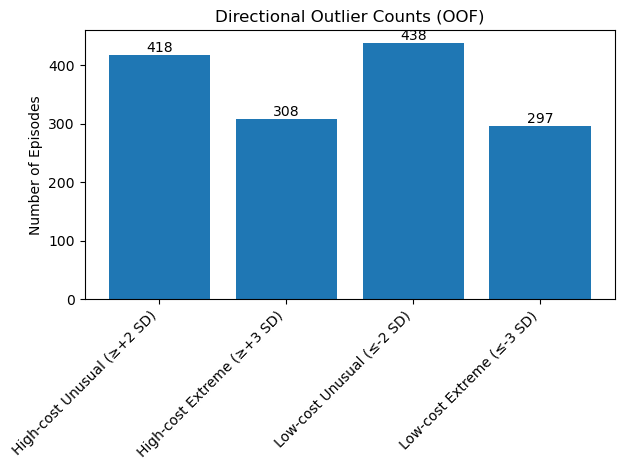

In [184]:
# Get counts
counts = outlier_oof_df["outlier_flag_directional"].value_counts()

# Ensure consistent order
ordered_categories = [
    "High-cost Unusual (≥+2 SD)",
    "High-cost Extreme (≥+3 SD)",
    "Low-cost Unusual (≤-2 SD)",
    "Low-cost Extreme (≤-3 SD)"
]

counts = counts.reindex(ordered_categories)

categories = counts.index.tolist()
values = counts.values

x = np.arange(len(categories))

plt.figure()

bars = plt.bar(x, values)

plt.xticks(x, categories, rotation=45, ha='right')
plt.ylabel("Number of Episodes")
plt.title("Directional Outlier Counts (OOF)")

# Add numeric labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


How the Model Was Used to Detect Outliers
The model was trained to predict expected hospital costs based on episode characteristics such as DRG, theatre utilisation, procedures, and length of stay.
To ensure fairness and avoid bias, out-of-fold cross-validation was used. This means each episode’s expected cost was generated by a model that was not trained on that episode.
For each case, we calculated:
Expected cost (risk-adjusted prediction)
Residual = Actual cost – Expected cost
Standardised residual (Z-score) = Residual relative to model error
Episodes were flagged as:
Unusual if ≥ 2 standard deviations above expected cost
Extreme if ≥ 3 standard deviations above expected cost
This approach allows identification of cases that cost materially more than would be expected given their clinical complexity.
In simple terms:
The model establishes a risk-adjusted benchmark, and outliers are cases that significantly exceed that benchmark.

Out-of-fold residual analysis identified approximately 2% of episodes costing more than three standard deviations above expected levels, with some cases exceeding 7–11 SD. These represent costs 7–21 times higher than predicted given episode characteristics.

### Check which cost segment unusual and extreme cases belong to

In [178]:
outlier_oof_df["total_charges"] = np.exp(outlier_oof_df["log_total_charges"])

# Calculate percentiles
p50 = outlier_oof_df["total_charges"].quantile(0.50)
p75 = outlier_oof_df["total_charges"].quantile(0.75)
p95 = outlier_oof_df["total_charges"].quantile(0.95)

def cost_segment_func(x):
    if x <= p50:
        return "Low"
    elif x <= p75:
        return "Medium"
    elif x <= p95:
        return "High"
    else:
        return "Very High"

outlier_oof_df["cost_segment"] = outlier_oof_df["total_charges"].apply(cost_segment_func)


In [179]:
segment_summary = (
    outlier_oof_df
    .groupby(["outlier_flag", "cost_segment"])
    .size()
    .reset_index(name="count")
    .sort_values(["outlier_flag", "count"], ascending=[True, False])
)

print(segment_summary)


       outlier_flag cost_segment  count
2   Extreme (≥3 SD)       Medium    193
0   Extreme (≥3 SD)         High    192
3   Extreme (≥3 SD)    Very High    112
1   Extreme (≥3 SD)          Low    108
5            Normal          Low  15588
6            Normal       Medium   6505
4            Normal         High   5332
7            Normal    Very High   1299
8   Unusual (≥2 SD)         High    352
10  Unusual (≥2 SD)       Medium    324
11  Unusual (≥2 SD)    Very High     99
9   Unusual (≥2 SD)          Low     81


In [180]:
crosstab = pd.crosstab(
    outlier_oof_df["cost_segment"],
    outlier_oof_df["outlier_flag"]
)

print(crosstab)


outlier_flag  Extreme (≥3 SD)  Normal  Unusual (≥2 SD)
cost_segment                                          
High                      192    5332              352
Low                       108   15588               81
Medium                    193    6505              324
Very High                 112    1299               99


In [181]:
crosstab_pct = pd.crosstab(
    outlier_oof_df["cost_segment"],
    outlier_oof_df["outlier_flag"],
    normalize="index"
) * 100

print(crosstab_pct.round(2))


outlier_flag  Extreme (≥3 SD)  Normal  Unusual (≥2 SD)
cost_segment                                          
High                     3.27   90.74             5.99
Low                      0.68   98.80             0.51
Medium                   2.75   92.64             4.61
Very High                7.42   86.03             6.56


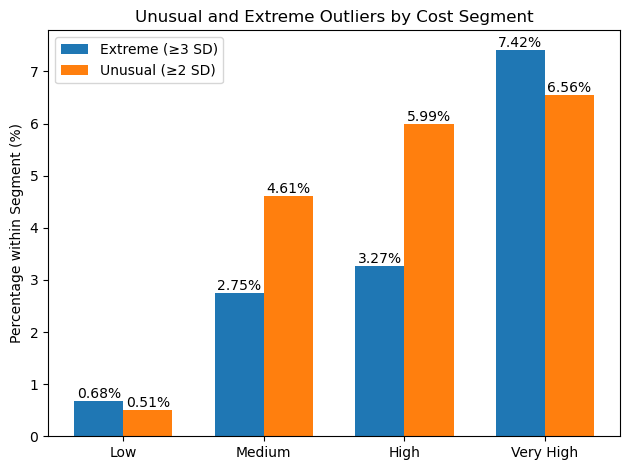

In [182]:
# Recalculate percentage table
crosstab_pct = pd.crosstab(
    outlier_oof_df["cost_segment"],
    outlier_oof_df["outlier_flag"],
    normalize="index"
) * 100

# Desired order
ordered_segments = ["Low", "Medium", "High", "Very High"]

# Reorder and select only Extreme + Unusual
plot_df = crosstab_pct.loc[ordered_segments, ["Extreme (≥3 SD)", "Unusual (≥2 SD)"]]

segments = plot_df.index.tolist()
x = np.arange(len(segments))
width = 0.35

plt.figure()

bars1 = plt.bar(x - width/2, plot_df["Extreme (≥3 SD)"], width, label="Extreme (≥3 SD)")
bars2 = plt.bar(x + width/2, plot_df["Unusual (≥2 SD)"], width, label="Unusual (≥2 SD)")

plt.xticks(x, segments)
plt.ylabel("Percentage within Segment (%)")
plt.title("Unusual and Extreme Outliers by Cost Segment")
plt.legend()

# Add numeric labels on top
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height,
             f"{height:.2f}%",
             ha='center',
             va='bottom')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height,
             f"{height:.2f}%",
             ha='center',
             va='bottom')

plt.tight_layout()
plt.show()


Extreme deviations are disproportionately concentrated in the highest cost segment, where clinical complexity and variability are greatest. The model maintains strong predictive alignment in low-cost cases, with less than 1% extreme deviation, indicating stability in lower-acuity episodes.

In the Low cost segment, only 0.68% of cases are classified as extreme (≥3 SD), and just 0.51% are unusual (≥2 SD). This indicates that for lower-acuity episodes, the model predicts cost very reliably. In practical terms, there is minimal unexplained variation in routine or low-complexity admissions. This reinforces confidence in the model’s baseline performance.

As cost intensity increases, deviation rates rise progressively:

Medium segment: 2.75% extreme, 4.61% unusual

High segment: 3.27% extreme, 5.99% unusual

Very High segment: 7.42% extreme, 6.56% unusual

The key insight is in the Very High cost segment, where 7.42% of cases are extreme outliers. This is more than 10 times the extreme rate observed in the Low segment (7.42% vs 0.68%). That concentration is statistically and operationally significant.

This pattern suggests:

The model performs consistently and predictably in low-complexity episodes.

Variability increases as clinical complexity increases — which is expected in healthcare.

A disproportionate share of unexplained cost occurs within already high-cost cases.

For executives, the implication is not that high-cost cases are inherently problematic — many may be clinically justified. Rather, it indicates that:

High-cost episodes represent the greatest financial uncertainty and risk.

This is where review processes will have the highest return on effort.

A targeted review strategy focusing on the Very High segment is more efficient than broad-based auditing.

Importantly, even in the Very High segment, 86% of cases remain within expected cost ranges, demonstrating that the model still explains the majority of complex admissions accurately.

Strategic Implication

The model is stable in low-acuity care and identifies concentration of financial deviation in high-acuity care. This enables:

Risk-adjusted monitoring

Focused insurer review of high-cost deviations

Identification of providers or pathways with disproportionate cost variation

In summary:

Cost deviation risk scales with clinical complexity.
The model provides a reliable baseline, and extreme deviations are concentrated where financial exposure is highest.

### Low cost outliers

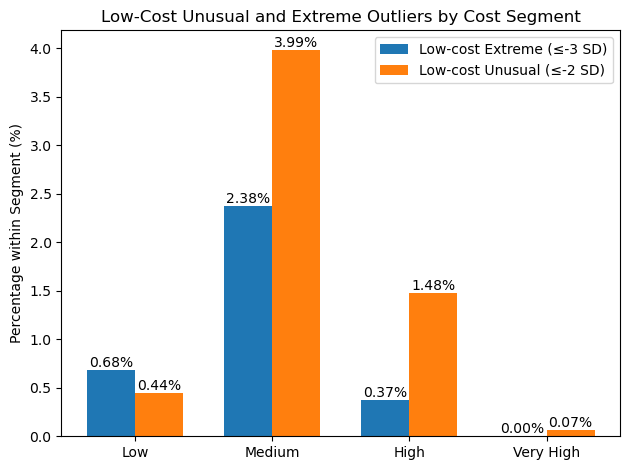

In [183]:
# Recalculate percentage table for directional flags
crosstab_pct_low = pd.crosstab(
    outlier_oof_df["cost_segment"],
    outlier_oof_df["outlier_flag_directional"],
    normalize="index"
) * 100

# Desired order
ordered_segments = ["Low", "Medium", "High", "Very High"]

# Select only low-cost categories
plot_df_low = crosstab_pct_low.loc[
    ordered_segments,
    ["Low-cost Extreme (≤-3 SD)", "Low-cost Unusual (≤-2 SD)"]
]

segments = plot_df_low.index.tolist()
x = np.arange(len(segments))
width = 0.35

plt.figure()

bars1 = plt.bar(x - width/2,
                plot_df_low["Low-cost Extreme (≤-3 SD)"],
                width,
                label="Low-cost Extreme (≤-3 SD)")

bars2 = plt.bar(x + width/2,
                plot_df_low["Low-cost Unusual (≤-2 SD)"],
                width,
                label="Low-cost Unusual (≤-2 SD)")

plt.xticks(x, segments)
plt.ylabel("Percentage within Segment (%)")
plt.title("Low-Cost Unusual and Extreme Outliers by Cost Segment")
plt.legend()

# Add numeric labels
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height,
             f"{height:.2f}%",
             ha='center',
             va='bottom')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height,
             f"{height:.2f}%",
             ha='center',
             va='bottom')

plt.tight_layout()
plt.show()


Medium Segment Has the Highest Low-Cost Deviations

2.38% extreme

3.99% unusual

Strategic Interpretation

High-cost outliers told us:

Financial risk concentrates in Very High segment.

Low-cost outliers tell us:

Efficiency variation concentrates in Medium segment.

That’s operationally meaningful.

Medium complexity care is often:

More standardised

Less catastrophic

More controllable

While extreme high-cost deviations are concentrated in the most complex cases, extreme low-cost deviations are concentrated in medium-complexity episodes. This suggests that efficiency variation is more prominent in moderate-acuity care, whereas high-acuity cases exhibit financial risk exposure rather than under-spend behaviour.

High-cost outliers → risk management
Low-cost outliers → operational efficiency insight